# Design Uncertainty a.k.a Reliability-based Robust Design Optimization

A multi-objective reliability-based robust design optimization problem is solved in the following. Please see the [publication](https://arxiv.org/pdf/2108.08890.pdf#Page=4) for a formal problem definition.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from duqo import UniVar, MultiVar, RRDO, FullSpace, ConditionalMoment, ConditionalProbability
from duqo.proba import DS



In [2]:
# Define the base functions
def scale_styta(x):
    if x.ndim < 2:
        x = x.reshape((1, -1))
    return np.sum(x ** 4 - 16 * x ** 2 + 5 * x, axis=1) / 180


def scale_lin(x):
    if x.ndim < 2:
        x = x.reshape((1, -1))
    return (5 * np.sqrt(x.shape[1]) - x.sum(1)) / 7


def himmblau(x, gamma=1):
    if x.ndim < 2:
        x = x.reshape((1, -1))
    res = ((x[:, 0] ** 2 + x[:, 1]) / 1.81 - 11) ** 2
    res += ((x[:, 0] + x[:, 1] ** 2) / 1.81 - 7) ** 2
    return res - 45 * gamma


In [3]:
# Define objectives and constraints
def obj_fun(x, locs=(0, 1)):
    if x.ndim < 2:
        x = x.reshape((1, -1))
    objs = np.zeros((x.shape[0], np.array(locs).size))
    # It is important to accepts locs as keyword argument
    # and return only the corresponding locations
    # This allows differentiating between uncertain and
    # deterministic objectives
    for i_loc, loc in enumerate(locs):
        if loc == 0:
            objs[:, i_loc] = scale_lin(x)
        elif loc == 1:
            objs[:, i_loc] = scale_styta(x)
    return objs


def con_fun(x, locs=(0, )):
    if x.ndim < 2:
        x = x.reshape((1, -1))
    cons = np.zeros((x.shape[0], np.array(locs).size))
    # locs are required to differentiate between deterministic
    # constraints and limit state functions similar to above
    for i_loc, loc in enumerate(locs):
        if loc == 0:
            cons[:, i_loc] = himmblau(x)
    return cons

In [4]:
# Define the optimization problem
multivar = MultiVar([UniVar("norm", mean=0., std=0.5) for _ in range(2)]) # Mean will be overridden by optimization
lower = np.array([-5, -5])
upper = np.array([5, 5])
num_obj = 2
num_con = 1
target_failure_probability = 1e-6
# By default, all variables are assumed uncertain. If there are additional deterministic variables
# These should be defined in FullSpace (see `help(FullSpace)` or the doc strings)
full_space = FullSpace(multivar, num_obj, num_con,
                       obj_fun=obj_fun,con_fun=con_fun
                       )
# NOTE: Following part of the API is planned to change.
# By default, mean and variance is returned for each stochastic objective
# For visualisation, we combine them linearly using (mu + 1.96 sigma).
# Conditonal moment allows us do this by defining obj_wgt and use_std
# to use standard deviation instead of variance
cmom = ConditionalMoment(full_space, obj_wgt=1.96, use_std=True) 
# ConditionalProbability is required to choose an integrator to use during optimization.
cprob = ConditionalProbability(target_failure_probability,
                               len(full_space.con_inds["sto"]), # Number of stochastic constraints
                               call_args={"multi_region": False}, # To speed-up evaluation
                               methods=[DS],
                               )
# Finally, we define the RRDO problem
problem = RRDO(full_space, co_fp=cprob, co_mom=cmom)

In [5]:
#Now, the problem can be used with any gradient-free optimizer. We can use `problem.evalaute` to evaluate a design:
x = np.zeros((1, 2)) + 1
objectives, feasibles, deterministic_constraints, failure_probabilities = problem.obj_con(x, verbose=4)
print("objectives", objectives) # Remember, these are mu + 1.96 * std
print("feasibles", feasibles) # A mask, where True means feasible wrt. both deterministic and probabilistic constraints
print("deterministic_constraints", deterministic_constraints) # Deterministic value of constraints and limit states
print("failure_probabilities", failure_probabilities) # Failure probabilities of limit states

Candidate 0: DS estimated the failure probability as 3.98e-05.
DS estimated the failure probability as 3.98e-05.
objectives [[0.92216052 0.02986657]]
feasibles [False]
deterministic_constraints [[87.66292238]]
failure_probabilities [[3.97662149e-05]]


In [6]:
# Let us randomly sample within the bounds
x = np.random.rand(1000, 2) * (upper - lower) + lower
objectives, feasibles, deterministic_constraints, failure_probabilities = problem.obj_con(x, verbose=1)

Candidate 0: DS estimated the failure probability as 1.93e-07.
Candidate 1: DS estimated the failure probability as 2.87e-04.
Skipping design 2 due to infeasibility.
Candidate 3: DS estimated the failure probability as 4.26e-05.
Candidate 4: DS estimated the failure probability as 1.20e-08.
Candidate 5: DS estimated the failure probability as 1.08e-05.
Candidate 6: DS estimated the failure probability as 2.07e-04.
Candidate 7: DS estimated the failure probability as 3.24e-02.
Candidate 8: DS estimated the failure probability as 3.25e-06.
Candidate 9: DS estimated the failure probability as 1.23e-01.
Candidate 10: DS estimated the failure probability as 0.00e+00.
Skipping design 11 due to infeasibility.
Skipping design 12 due to infeasibility.
Candidate 13: DS estimated the failure probability as 4.32e-06.
Candidate 14: DS estimated the failure probability as 0.00e+00.
Skipping design 15 due to infeasibility.
Candidate 16: DS estimated the failure probability as 8.78e-02.
Candidate 17: 

Candidate 145: DS estimated the failure probability as 3.11e-05.
Skipping design 146 due to infeasibility.
Candidate 147: DS estimated the failure probability as 3.96e-10.
Candidate 148: DS estimated the failure probability as 0.00e+00.
Candidate 149: DS estimated the failure probability as 3.01e-02.
Candidate 150: DS estimated the failure probability as 0.00e+00.
Candidate 151: DS estimated the failure probability as 1.19e-02.
Candidate 152: DS estimated the failure probability as 5.39e-08.
Skipping design 153 due to infeasibility.
Candidate 154: DS estimated the failure probability as 5.71e-06.
Candidate 155: DS estimated the failure probability as 4.64e-05.
Skipping design 156 due to infeasibility.
Candidate 157: DS estimated the failure probability as 1.90e-01.
Candidate 158: DS estimated the failure probability as 4.24e-01.
Candidate 159: DS estimated the failure probability as 9.30e-02.
Skipping design 160 due to infeasibility.
Candidate 161: DS estimated the failure probability 

Candidate 288: DS estimated the failure probability as 1.14e-07.
Candidate 289: DS estimated the failure probability as 0.00e+00.
Candidate 290: DS estimated the failure probability as 4.98e-02.
Candidate 291: DS estimated the failure probability as 6.23e-02.
Candidate 292: DS estimated the failure probability as 2.19e-02.
Candidate 293: DS estimated the failure probability as 5.76e-03.
Candidate 294: DS estimated the failure probability as 4.06e-01.
Candidate 295: DS estimated the failure probability as 2.47e-02.
Skipping design 296 due to infeasibility.
Candidate 297: DS estimated the failure probability as 2.93e-06.
Skipping design 298 due to infeasibility.
Candidate 299: DS estimated the failure probability as 2.05e-09.
Skipping design 300 due to infeasibility.
Candidate 301: DS estimated the failure probability as 7.26e-07.
Skipping design 302 due to infeasibility.
Candidate 303: DS estimated the failure probability as 0.00e+00.
Candidate 304: DS estimated the failure probability 

Candidate 432: DS estimated the failure probability as 3.23e-01.
Candidate 433: DS estimated the failure probability as 2.88e-05.
Skipping design 434 due to infeasibility.
Candidate 435: DS estimated the failure probability as 2.06e-01.
Candidate 436: DS estimated the failure probability as 1.22e-04.
Candidate 437: DS estimated the failure probability as 1.28e-02.
Candidate 438: DS estimated the failure probability as 2.53e-06.
Skipping design 439 due to infeasibility.
Candidate 440: DS estimated the failure probability as 4.38e-01.
Skipping design 441 due to infeasibility.
Candidate 442: DS estimated the failure probability as 0.00e+00.
Candidate 443: DS estimated the failure probability as 0.00e+00.
Candidate 444: DS estimated the failure probability as 3.87e-02.
Skipping design 445 due to infeasibility.
Candidate 446: DS estimated the failure probability as 0.00e+00.
Skipping design 447 due to infeasibility.
Candidate 448: DS estimated the failure probability as 3.60e-09.
Candidate 

Candidate 575: DS estimated the failure probability as 1.16e-04.
Skipping design 576 due to infeasibility.
Skipping design 577 due to infeasibility.
Candidate 578: DS estimated the failure probability as 8.47e-05.
Candidate 579: DS estimated the failure probability as 1.52e-02.
Candidate 580: DS estimated the failure probability as 4.89e-06.
Skipping design 581 due to infeasibility.
Candidate 582: DS estimated the failure probability as 1.20e-07.
Candidate 583: DS estimated the failure probability as 2.18e-02.
Candidate 584: DS estimated the failure probability as 8.40e-04.
Candidate 585: DS estimated the failure probability as 0.00e+00.
Skipping design 586 due to infeasibility.
Candidate 587: DS estimated the failure probability as 3.57e-04.
Candidate 588: DS estimated the failure probability as 0.00e+00.
Candidate 589: DS estimated the failure probability as 7.69e-10.
Candidate 590: DS estimated the failure probability as 5.41e-06.
Skipping design 591 due to infeasibility.
Candidate 

Candidate 717: DS estimated the failure probability as 1.18e-01.
Candidate 718: DS estimated the failure probability as 1.49e-02.
Candidate 719: DS estimated the failure probability as 1.37e-01.
Candidate 720: DS estimated the failure probability as 6.91e-09.
Candidate 721: DS estimated the failure probability as 5.27e-02.
Candidate 722: DS estimated the failure probability as 1.85e-01.
Candidate 723: DS estimated the failure probability as 6.78e-02.
Candidate 724: DS estimated the failure probability as 2.30e-02.
Candidate 725: DS estimated the failure probability as 1.56e-03.
Candidate 726: DS estimated the failure probability as 1.67e-01.
Candidate 727: DS estimated the failure probability as 2.16e-05.
Candidate 728: DS estimated the failure probability as 8.62e-02.
Candidate 729: DS estimated the failure probability as 9.75e-02.
Candidate 730: DS estimated the failure probability as 0.00e+00.
Skipping design 731 due to infeasibility.
Candidate 732: DS estimated the failure probabil

Candidate 858: DS estimated the failure probability as 6.78e-03.
Candidate 859: DS estimated the failure probability as 3.73e-01.
Skipping design 860 due to infeasibility.
Candidate 861: DS estimated the failure probability as 7.53e-04.
Candidate 862: DS estimated the failure probability as 1.58e-06.
Skipping design 863 due to infeasibility.
Candidate 864: DS estimated the failure probability as 7.10e-02.
Candidate 865: DS estimated the failure probability as 6.74e-02.
Candidate 866: DS estimated the failure probability as 2.96e-02.
Candidate 867: DS estimated the failure probability as 2.08e-04.
Candidate 868: DS estimated the failure probability as 8.52e-02.
Skipping design 869 due to infeasibility.
Candidate 870: DS estimated the failure probability as 4.27e-03.
Candidate 871: DS estimated the failure probability as 1.11e-01.
Candidate 872: DS estimated the failure probability as 2.94e-01.
Candidate 873: DS estimated the failure probability as 1.03e-08.
Candidate 874: DS estimated t

Candidate 999: DS estimated the failure probability as 3.61e-04.


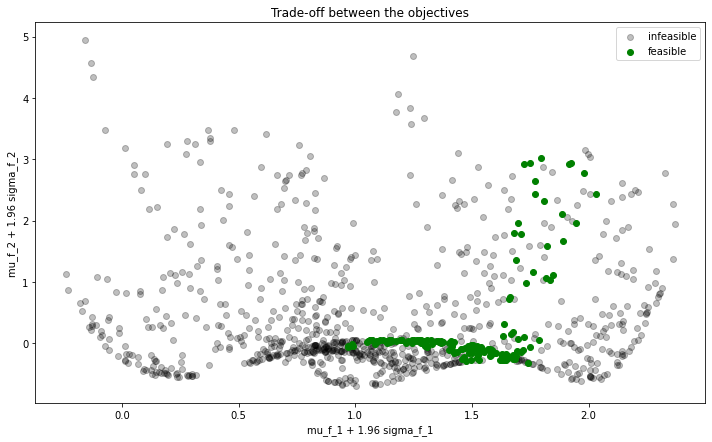

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))
infeasibles = np.logical_not(feasibles)
_ = ax.scatter(objectives[infeasibles, 0], objectives[infeasibles, 1], color="k", label="infeasible", alpha=0.25)
_ = ax.scatter(objectives[feasibles, 0], objectives[feasibles, 1], color="g", label="feasible")
_ = ax.set_xlabel("mu_f_1 + 1.96 sigma_f_1")
_ = ax.set_ylabel("mu_f_2 + 1.96 sigma_f_2")
_ = ax.set_title("Trade-off between the objectives")
_ = ax.legend()